In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob # 文件路径处理
import os

In [3]:
# 获取所有训练图像路径
train_image_path = glob.glob('./dataset/dc_2000/train/*/*.jpg')

In [4]:
len(train_image_path)

2000

In [5]:
train_image_path[:5]

['./dataset/dc_2000/train\\cat\\cat.0.jpg',
 './dataset/dc_2000/train\\cat\\cat.1.jpg',
 './dataset/dc_2000/train\\cat\\cat.10.jpg',
 './dataset/dc_2000/train\\cat\\cat.100.jpg',
 './dataset/dc_2000/train\\cat\\cat.101.jpg']

In [6]:
train_image_path[-5:]

['./dataset/dc_2000/train\\dog\\dog.995.jpg',
 './dataset/dc_2000/train\\dog\\dog.996.jpg',
 './dataset/dc_2000/train\\dog\\dog.997.jpg',
 './dataset/dc_2000/train\\dog\\dog.998.jpg',
 './dataset/dc_2000/train\\dog\\dog.999.jpg']

In [7]:
# 提取图片路径中的label  cat为1，dog为0
train_image_label = [int(p.split('\\')[1] == 'cat') for p in train_image_path]

In [8]:
train_image_label[-5:]

[0, 0, 0, 0, 0]

In [9]:
# 通过路径读取图片
def load_preprosess_image(path,label):
    image = tf.io.read_file(path)
    #解码
    image = tf.image.decode_jpeg(image,channels=3)
    #将图像处理成相同大小
    image = tf.image.resize(image,[360,360])
    # 数据增强
    image = tf.image.random_crop(image,[256,256,3]) # 随机裁剪
    image = tf.image.random_flip_left_right(image) # 随机左右翻转
    image = tf.image.random_flip_up_down(image) # 随机上下翻转
    image = tf.image.random_brightness(image,0.5) # 随机调整亮度
    image = tf.image.random_contrast(image,0,1) # 随机对比度
    
    #改变数据类型
    image = tf.cast(image,tf.float32)
    #归一化
    image = image/255
    
    #将label处理成二维的: [1,2,3] ---> [[1],[2],[3]]
    label = tf.reshape(label,[1])
    return image,label

In [10]:
# 原数据不是float类型时转换数据类型时默认做归一化   原数据是float类型转换时不做归一化
# tf.image.convert_image_dtype 

In [11]:
# 创建dataset
train_image_ds = tf.data.Dataset.from_tensor_slices((train_image_path,train_image_label))

In [12]:
train_image_ds

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>

In [11]:
# 根据计算机cpu的个数自动做并行运算
AUTOTUNE =tf.data.experimental.AUTOTUNE

In [12]:
# map:将变化应用在所有数据上，num_parallel_calls：是否进行并行运算
train_image_ds = train_image_ds.map(load_preprosess_image,num_parallel_calls=AUTOTUNE)

In [13]:
train_image_ds

<ParallelMapDataset shapes: ((256, 256, 3), (1,)), types: (tf.float32, tf.int32)>

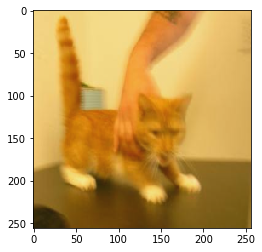

In [14]:
for img,label in train_image_ds.take(1):
    plt.imshow(img)

In [15]:
BATCH_SIZE = 32
train_count = len(train_image_path)

In [16]:
train_image_ds = train_image_ds.shuffle(train_count).batch(BATCH_SIZE)
# 在计算机后台预先加载数据：参数为加载数据的大小--AUTOTUNE表示让计算机自己决定
train_image_ds = train_image_ds.prefetch(AUTOTUNE)

In [17]:
train_image_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 1)), types: (tf.float32, tf.int32)>

In [18]:
test_image_path = glob.glob('./dataset/dc_2000/test/*/*.jpg')
test_image_label = [int(p.split('\\')[1] == 'cat') for p in test_image_path]
test_image_ds = tf.data.Dataset.from_tensor_slices((test_image_path,test_image_label))
test_image_ds = test_image_ds.map(load_preprosess_image,num_parallel_calls=AUTOTUNE)
test_image_ds = test_image_ds.batch(BATCH_SIZE)
# 在计算机后台预先加载数据：参数为加载数据的大小--AUTOTUNE表示让计算机自己决定
test_image_ds = test_image_ds.prefetch(AUTOTUNE)

In [19]:
# iter(train_image_ds):使用iter将数据集转换为生成器，然后使用next按批次取数据
imgs,labels = next (iter (train_image_ds))()

In [63]:
model = keras.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),input_shape=(256,256,3),padding = 'same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256,(1,1),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512,(1,1),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512,(1,1),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4096,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4096,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1000,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])


"""model = keras.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),input_shape=(256,256,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(1024,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
]) """

"model = keras.Sequential([\n    tf.keras.layers.Conv2D(64,(3,3),input_shape=(256,256,3),activation='relu'),\n    tf.keras.layers.BatchNormalization(),\n    tf.keras.layers.MaxPooling2D(),\n    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),\n    tf.keras.layers.BatchNormalization(),\n    tf.keras.layers.MaxPooling2D(),\n    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),\n    tf.keras.layers.BatchNormalization(),\n    tf.keras.layers.MaxPooling2D(),\n    tf.keras.layers.Conv2D(512,(3,3),activation='relu'),\n    tf.keras.layers.BatchNormalization(),\n    tf.keras.layers.MaxPooling2D(),\n    tf.keras.layers.Conv2D(1024,(3,3),activation='relu'),\n    tf.keras.layers.BatchNormalization(),\n    tf.keras.layers.GlobalAveragePooling2D(),\n    tf.keras.layers.Dense(1024,activation='relu'),\n    tf.keras.layers.BatchNormalization(),\n    tf.keras.layers.Dense(256,activation='relu'),\n    tf.keras.layers.BatchNormalization(),\n    tf.keras.layers.Dense(1)\n]) "

In [64]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_80 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 254, 254, 64)      36928     
_________________________________________________________________
batch_normalization_81 (Batc (None, 254, 254, 64)      256       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 125, 125, 128)     73856     
_________________________________________________________________
batch_normalization_82 (Batc (None, 125, 125, 128)    

In [65]:
pred = model(imgs)

In [66]:
# 列表表达式
# 使用模型进行预测
np.array([p[0].numpy() for p in tf.cast(pred > 0.5,tf.int32)])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [67]:
# 实际的label
np.array([l[0] for l in labels])

array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1])

In [68]:
optimizer = tf.keras.optimizers.Adam()

In [69]:
# 使用metrics计算
epoch_loss_avg = tf.keras.metrics.Mean('train_loss')
train_accuracy = tf.keras.metrics.Accuracy()

# 使用metrics计算
epoch_loss_avg_test = tf.keras.metrics.Mean('test_loss')
test_accuracy = tf.keras.metrics.Accuracy()

In [70]:
def train_step(model,images,labels):
    with tf.GradientTape() as t:
        pred = model(images)
        loss_step = tf.keras.losses.BinaryCrossentropy(from_logits = True)(labels,pred)
    grads = t.gradient(loss_step,model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))
    epoch_loss_avg(loss_step)
    train_accuracy(labels,tf.cast(pred > 0,tf.int32))

In [71]:
def test_step(model,images,labels):
    pred = model(images,training = False) # 使用非训练状态
    loss_step = tf.keras.losses.BinaryCrossentropy(from_logits = True)(labels,pred)
    epoch_loss_avg_test(loss_step)
    test_accuracy(labels,tf.cast(pred > 0,tf.int32))

In [72]:
# 定义列表记录数据
train_loss_result = []
train_acc_result = []

test_loss_result = []
test_acc_result = []

In [73]:
num_epoch =30

In [75]:
for epoch in range(num_epoch):
    for imgs_, labels_ in train_image_ds:
        train_step(model, imgs_, labels_)
        print('.', end='')
    print()
    
    train_loss_result.append(epoch_loss_avg.result())
    train_acc_result.append(train_accuracy.result())
    
    
    for imgs_, labels_ in test_image_ds:
        test_step(model, imgs_, labels_)
        
    test_loss_result.append(epoch_loss_avg_test.result())
    test_acc_result.append(test_accuracy.result())
    
    print('Epoch:{}: loss: {:.3f}, accuracy: {:.3f}, test_loss: {:.3f}, test_accuracy: {:.3f}'.format(
        epoch + 1,
        epoch_loss_avg.result(),
        train_accuracy.result(),
        epoch_loss_avg_test.result(),
        test_accuracy.result()
    ))
    
    epoch_loss_avg.reset_states()
    train_accuracy.reset_states()
    
    epoch_loss_avg_test.reset_states()
    test_accuracy.reset_states()

..........................

KeyboardInterrupt: 